In [1]:
# This homework assignment brought to you by Alyssa playing the Shrek (2001) soundtrack on repeat
# On parts of this assignment, I worked with the following classmates (in ~ chronological order): 
# Rachel Losacco, Michael Estrada, Sheila Sagear, Francisco Mendez, and Christina Moraitis

# Import statements
from ccdproc import ImageFileCollection
from ccdproc.utils.sample_directory import sample_directory_with_files
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from photutils import centroid_sources
import os # for debugging

# Import images of h Persei, dark frames, and flat frames
dir = "2020-10-17" # Define directory with images
ic_images = ImageFileCollection(dir, keywords='*', glob_include='h_persei_seq*', glob_exclude='*bad*') # Get science images
ic_darks = ImageFileCollection(dir, keywords='*', glob_include='h_persei_darks*') # Get dark frames
ic_flats = ImageFileCollection(dir, keywords='*', glob_include='h_persei_flats*') # Get flat frames
# ic_images.summary.colnames

# 1. Data processing

Our first goal is to create a **final science image in the V band**. To accomplish this, we will need to **flat-field-correct** and **dark-subtract** the individual science frames before median-combining the individual science frames.

First, I will create a **final dark frame** at each exposure time for which we have science images and flat frames. For the science images, there are only 5 second exposures in the V band, and the same is true for the flat frames in the V band.

In [2]:
# Median combine dark frames at each exposure time (just 5 seconds in this case)
h_per_darks_5s_files = ic_darks.files_filtered(exptime=5) # Retrieve dark frame files with 5s exposure time
# print(h_per_darks_5s_files)
##### Note to future self: I really need to put the code below into a function!
h_per_darks_5s = [] # Initialize array for imported dark frames
for i in range(len(h_per_darks_5s_files)): # Loop over each dark frame file
    h_per_darks_5s.append(fits.getdata(dir+"/"+h_per_darks_5s_files[i])) # Put data from each dark frame in array

h_per_darks_5s = np.array(h_per_darks_5s) # Convert dark frame array to a numpy array
h_per_darks_5s.shape # (10, 1266, 1676), note that these are a different shape from the CCD lab evaluation images
h_per_final_dark_5s = np.median(h_per_darks_5s, axis=0) # Median combine all 10 dark frames

Next, I will create a **final flat frame** for each filter we're using. For this exercise, we are only considering the V filter. All V filter flat frames taken have 5 second exposure times. I will median-combine each of the flat frames in the V band and then subtract my **final dark frame** at the correct exposure time to get my **final flat frame** in the V band. I'll also normalize that **final flat frame** by dividing each value in the array by the median value of the array.

In [3]:
# Median combine flat frames for each filter (just the V band, at 5 seconds in this case)
h_per_flats_V_files = ic_flats.files_filtered(filter='V') # Retrieve flat frame files in the V band
# print(h_per_flats_V_files)
h_per_flats_V = [] # Initialize array for imported flat frames
for i in range(len(h_per_flats_V_files)): # Loop over each flat frame file
    h_per_flats_V.append(fits.getdata(dir+"/"+h_per_flats_V_files[i])) # Put data from each flat frame in array

h_per_flats_V = np.array(h_per_flats_V) # Convert flat frame array to a numpy array
h_per_flats_V.shape # (5, 1266, 1676), note that these are a different shape from the CCD lab evaluation images
h_per_flats_V_med = np.median(h_per_flats_V, axis=0) # Median combine all 5 flat frames

h_per_final_flat_V = h_per_flats_V_med - h_per_final_dark_5s # Perform dark-subtraction on the final flat image
# h_per_final_flat_V[h_per_final_flat_V == 0] = np.nan # Convert zeros to NaNs in the final flat (unnormalized)
h_per_final_flat_V_norm = h_per_final_flat_V/np.median(h_per_final_flat_V) # Normalize the final flat image
# print(np.median(h_per_final_flat_V_norm)) # Checking that the median value is 1

Now, I will perform dark-subtraction and flat-field-correction on our science frames in the V band. Since we are only working with a single exposure time, this process is simplified. First, I'll dark-subtract each individual science frame using the **final dark frame** with the correct exposure time. Then, I'll flat-field correct each individual science frame using the **final flat frame** for the correct filter.

In [4]:
h_per_images_V_files = ic_images.files_filtered(filter='V') # Select science frame files in the V band
# print(h_per_images_V)
h_per_images_V = [] # Initialize array for imported image frames
for i in range(len(h_per_images_V_files)): # Loop over each image frame file
    h_per_images_V.append(fits.getdata(dir+"/"+h_per_images_V_files[i])) # Put data from each image frame in array
    
h_per_images_V = np.array(h_per_images_V) # Convert image frame array to a numpy array
h_per_images_V.shape # (10, 1266, 1676), note that these are a different shape from the CCD lab evaluation images

# Perform dark subtraction on each image frame in the array
h_per_images_V_d = h_per_images_V - h_per_final_dark_5s[np.newaxis,:,:] # Use array broadcasting to dark-subtract

# Perform flat-field correction on each image frame in the array
h_per_images_V_d_f = h_per_images_V_d/h_per_final_flat_V_norm[np.newaxis,:,:] # Use array broadcasting to flat-field correct

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Penultimately, we can align our individual science frames. I will do this by measuring the centroid of the same star in each science frame using photutils.centroids.centroid_sources. I will then use np.roll() to shift each frame by the appropriate amount of pixels so that each other frame is aligned with the first.

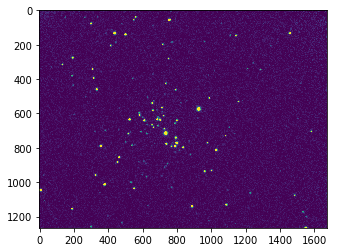

In [5]:
first_image = h_per_images_V_d_f[0]
other_images = h_per_images_V_d_f[1:]
plt.imshow(first_image, vmin=0, vmax=1000) # Plot an image to try to locate star (coords same in DS9)
x_init = 974 # Define initial x-coordinate guess for star
y_init = 771 # Define initial y-coordinate guess for star
x_first, y_first = centroid_sources(first_image, 600, 950, box_size=20) # Calculate centroid of star
x_first = x_first[0] # Extract value from array
y_first = y_first[0] # Extract value from array
# print(x_first, y_first)

x_shifts = [] # Initialize list of x shifts
y_shifts = [] # Initialize list of y shifts
for frame in other_images: # Loop over rest of image frames
    x, y = centroid_sources(frame, x_init, y_init, box_size=20) # Calculate the centroid of the same star in that image
    x_shifts.append(x_first - x[0]) # Calculate the x shift necessary (first minus individual) and record
    y_shifts.append(y_first - y[0]) # Calculate the y shift necessary (first minus individual) and record
    
for i in range(len(other_images)): # Loop over rest of image frames
    x_shift = int(np.rint(x_shifts[i])) # Round x shift to nearest integer, turn into integer (same for y below)
    y_shift = int(np.rint(y_shifts[i])) # It ticks me off that I need to wrap this in int()
    np.roll(h_per_images_V_d_f[i+1], (x_shift, y_shift)) # Shift original frames by specified amount
    
h_per_images_V_d_f_s = h_per_images_V_d_f # Note that image frames are now shifted

Finally, I will median-combine the science frames to get our final science image.

In [6]:
h_per_final_image = np.median(h_per_images_V_d_f_s, axis=0) # Median combine all 10 image frames
hdu = fits.PrimaryHDU(h_per_final_image) # Create HDU for final science image
hdu.writeto('h_per_V.fits', overwrite=True) # Write to a new .fits file

/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median for 1440 results
  r = func(a, **kwargs)


# 2. PSF characteristics

First, I will find "bright" peaks in our final image.

x_peak y_peak     peak_value    
------ ------ ------------------
   433    134 12932.511550503483
   795    771 10250.938666318674
   785    790  6355.619609412312


(0, 1265)

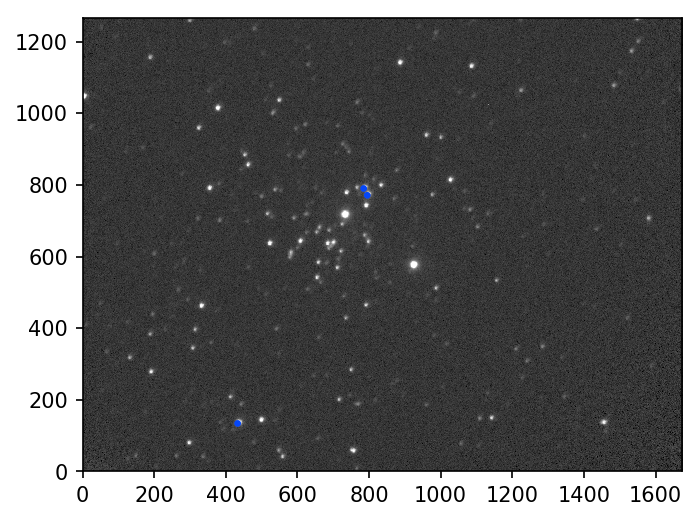

In [7]:
# The commented code below does not work, sadly
# from photutils import centroid_sources, centroid_com

# x_init = (1028, 379, 332, 1156, 1089) # Define initial x-values for bright stars (identified by eye)
# y_init = (813, 1015, 463, 533, 1128) # Define initial y-values for bright stars (identified by eye)
# x, y = centroid_sources(h_per_final_image, x_init, y_init, box_size=20, centroid_func=centroid_com) # Centroids
# x = x.astype(int) # Convert centroid x-values to integer (does not round, I don't think)
# y = y.astype(int) # Convert centroid y-values to integer (does not round, I don't think)

# Source for this code: https://photutils.readthedocs.io/en/stable/detection.html
from astropy.stats import sigma_clipped_stats
from photutils import find_peaks
from astropy.table import Table

mean, median, std = sigma_clipped_stats(h_per_final_image, sigma=3.0) # Calculate the mean/median/stddev of image above 3 sigma
threshold = median + (5. * std) # Set a 5 sigma threshold to find peaks
tbl = find_peaks(h_per_final_image, threshold, box_size=11) # Find peaks above 5 sigma
tbl['peak_value'].info.format = '%.8g'  # For consistent table output
df = tbl.to_pandas() # Convert from astropy table to pandas dataframe (should be able to do w/ astropy, though)
bright_peaks = df.loc[(df['peak_value']<50000)&(df['peak_value']>5700)] # Take only "bright" peaks
bright_peaks = Table.from_pandas(bright_peaks) # Convert back from pandas df to astropy table
print(bright_peaks) # See what peaks were found

from astropy.visualization import simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture
positions = np.transpose((bright_peaks['x_peak'], bright_peaks['y_peak']))
apertures = CircularAperture(positions, r=5.)
norm = simple_norm(h_per_final_image, 'sqrt', percent=99.9)
plt.figure(dpi=150)
plt.imshow(h_per_final_image, cmap='Greys_r', origin='lower', norm=norm,
           interpolation='nearest')
apertures.plot(color='#0547f9', lw=1.5)
plt.xlim(0, h_per_final_image.shape[1]-1)
plt.ylim(0, h_per_final_image.shape[0]-1)

Next, I will determine the FWHM of the peaks I found in the previous step by fitting a 1D Gaussian function to the row the peak is in at a point along the row near to the peak (within 20 pixels on each side of the peak). I will average together the sigma values I get from each peak fit. Then, I will convert that sigma value to a FWHM.

In [8]:
from scipy.optimize import curve_fit

def gauss(x, a, mu, sigma):
    return a*np.exp(-.5*(x-mu)**2/(sigma**2))

# This was an attempt at 2D Gaussian fitting, which didn't work (I think I got x and y switched)
# def gauss2D(coord, a, x_0, y_0, sigma_x, sigma_y):
#     x_inp, y_inp = coord
#     result = a*np.exp((((x_inp - x_0)**2)/(2*(sigma_x**2))) + (((y_inp - y_0)**2)/(2*(sigma_y**2)))) # Too many parentheses because I am paranoid
#     return result.ravel()
# popt, pcov = curve_fit(gauss2D, (x_mesh, y_mesh), subregion.ravel(), p0=[200.,20.,20.,5.,5.])

sigma_values = [] # Initialize list of sigma values
for i in np.arange(len(bright_peaks)):
    x_coord = bright_peaks[i][0] # Get x-coordinate of center of peak
    y_coord = bright_peaks[i][1] # Get y-coordinate of center of peak
    subregion = h_per_final_image[y_coord-10:y_coord+10,x_coord] # Get region around peak--remember, y then x
    x = np.arange(len(subregion)) # Create an array of relative pixel values
    popt, pcov = curve_fit(gauss, xdata=x, ydata=subregion, p0=[1,1,1]) # Perform Gaussian fit on values near peak
    print("Sigma value:",np.abs(popt[2])) # Print out fit sigma parameter
    sigma_values.append(np.abs(popt[2])) # Record fit sigma parameter

#     plt.figure(dpi=150)
#     plt.plot(x,subregion,'b+:',label='data')
#     plt.plot(x,gauss(x,*popt),'ro:',label='fit')
#     plt.legend()
#     plt.title('Slice of image near peak')
#     plt.xlabel('Relative x-coordinate')
#     plt.ylabel('Pixel value')
#     plt.show()

sigma_values = np.asarray(sigma_values) # Change list of sigma values in to numpy array
print("The mean sigma value for the fit stars is",np.mean(sigma_values))

Sigma value: 2.9875261666497614
Sigma value: 2.9511538587584623
Sigma value: 2.737556969445751
The mean sigma value for the fit stars is 2.892078998284658


We can then convert this sigma value into the FWHM.

In [9]:
from astropy.stats import gaussian_sigma_to_fwhm
FWHM = np.mean(sigma_values)*gaussian_sigma_to_fwhm
print("FWHM (pixels):",FWHM)

FWHM (pixels): 6.810325596973741


Now, I'll compare our image of h Persei to an archival image of the cluster. I got one from Aladin: http://aladin.unistra.fr/AladinLite/?target=02%2019%201.552%2B57%2008%2036.45&fov=0.24&survey=P%2FDSS2%2Fcolor

I will record the right ascension and declination for two stars using their Gaia DR2 coordinates. I will then measure the angular separation between those stars from the Aladin image. Then, using our science image of h Persei taken with RHO, I will measure the centroids of those same two stars and use the distance formula to measure the distance in pixels between them. From that distance, I will be able to estimate the pixel scale of the image (in arcseconds/pixel).

Lastly, I will convert our measured FWHM in pixels to the FWHM in arcseconds.

In [10]:
from astropy.coordinates import Angle
from astropy.coordinates import SkyCoord
import astropy.units as u

star_A_icrs = SkyCoord(ra='34.75720423950d', dec='57.17865241550d', frame='icrs') # Define star A coords (Gaia)
star_B_icrs = SkyCoord(ra='34.73680897220d', dec='57.18089296620d', frame='icrs') # Define star B coords (Gaia)
sep_gaia = star_A_icrs.separation(star_B_icrs) # Calculate separation between Gaia coordinates
print("Angular separation from Gaia (arcsec):",sep_gaia.arcsecond)

from photutils import centroid_sources, centroid_com
x_A, y_A = 465, 792 # Define initial guess for star A coords (RHO) (I switched x and y from what DS9 gives)
x_B, y_B = 429, 735 # Define initial guess for star B coords (RHO) (I switched x and y from what DS9 gives)
x_init = (x_A, x_B) # Group x coordinates into array
y_init = (y_A, y_B) # Group y coordinates into array
x_centroids, y_centroids = centroid_sources(h_per_final_image, x_init, y_init, box_size=20, centroid_func=centroid_com) # Centroids
x_centroids = x_centroids.astype(int) # Convert centroid x-values to integer (does not round, I don't think)
y_centroids = y_centroids.astype(int) # Convert centroid y-values to integer (does not round, I don't think)
x_0, x_1 = x_centroids[0], x_centroids[1] # Redefine centroids nicely
y_0, y_1 = y_centroids[0], y_centroids[1] # Redefine centroids nicely
sep_rho = np.sqrt(((x_0 - x_1)**2) + ((y_0 - y_1)**2)) # Calculate pixel distance between stars
print("Pixel separation from RHO (pixels)",sep_rho)

pixel_scale = sep_gaia.arcsecond/sep_rho # Calculate estimated pixel scale of image
print("Estimated pixel scale of image (arcsec/pixel):",pixel_scale)

FWHM_arcsec = FWHM*pixel_scale
print("FWHM (arcsec):",FWHM_arcsec)

Angular separation from Gaia (arcsec): 40.604807677392934
Pixel separation from RHO (pixels) 69.33974329343886
Estimated pixel scale of image (arcsec/pixel): 0.5855921257965645
FWHM (arcsec): 3.9880730436986105


# 3. Aperture photometry

First, I will begin by picking out "bright," "medium," and "faint" stars using their peak counts.

In [11]:
from astropy.table import vstack

# I'll use the dataframe of stars from our final image from before
bright_stars = df.loc[(df['peak_value']<50000)&(df['peak_value']>10000)] # Take only "bright" stars
medium_stars = df.loc[(df['peak_value']<4500)&(df['peak_value']>4400)] # Take only "medium" stars
faint_stars = df.loc[(df['peak_value']<2000)&(df['peak_value']>1750)] # Take only "faint" stars
bright_stars = Table.from_pandas(bright_stars) # Convert back from pandas df to astropy table
medium_stars = Table.from_pandas(medium_stars) # Convert back from pandas df to astropy table
faint_stars = Table.from_pandas(faint_stars) # Convert back from pandas df to astropy table
print(bright_stars) # See what stars were found
print(medium_stars) # See what stars were found
print(faint_stars) # See what stars were found

photom_stars = vstack([bright_stars,medium_stars,faint_stars])
photom_stars_x, photom_stars_y = photom_stars['x_peak'], photom_stars['y_peak']

x_peak y_peak     peak_value    
------ ------ ------------------
   433    134 12932.511550503483
   795    771 10250.938666318674
x_peak y_peak     peak_value   
------ ------ -----------------
   330    460 4424.004674457429
   520    635 4474.952067175182
x_peak y_peak     peak_value    
------ ------ ------------------
   296     78 1992.6782102135508
   957    937  1797.434620076339


Now, I'll create an aperture on each star that's 1.3 times the FWHM in radius. I'll calculate the raw intensity on each star as well as the number of pixels in the aperture. 

Next, I'll calculate the median intensity per pixel (F_sky_pix) in the sky aperture (annulus) I created above. Then, I'll "sky-subtract" the sky background from my target flux (F_targ = F_targ_raw - N_targ\*F_sky_pix).

Then, I'll convert the fluxes to instrumental magnitudes.

In [12]:
# Source for this code: https://photutils.readthedocs.io/en/stable/aperture.html#performing-aperture-photometry
from photutils import aperture_photometry, CircularAperture, CircularAnnulus
from astropy.visualization import simple_norm

def photometry(targ_rad, sky_inner, sky_outer):
    target_flux_sky_sub = []
    for i in range(len(photom_stars_x)):
        star_aperture = CircularAperture((photom_stars_x[i], photom_stars_y[i]), r=targ_rad*FWHM) # Define star aperture
        # Define sky annulus
        sky_annulus = CircularAnnulus((photom_stars_x[i], photom_stars_y[i]), r_in=sky_inner*FWHM, r_out=sky_outer*FWHM)

        # Code from Francisco (adapted by me) to plot where the star aperture and sky annulus will be
    #     plt.figure(dpi=150)
    #     norm = simple_norm(h_per_final_image, 'sqrt', percent=99)
    #     plt.title("Aperture and annulus")
    #     plt.imshow(h_per_final_image_b, cmap='gray', origin='lower', norm=norm)
    #     star_aperture.plot(color='yellow')
    #     sky_annulus.plot(color='orange')
    #     plt.show()

        apertures = [star_aperture, sky_annulus] # Create array of apertures
        phot_table = aperture_photometry(h_per_final_image, apertures, method='exact') # Perform aperture photometry
    #     print(phot_table) # Print out photometry

        F_targ_raw = float(phot_table['aperture_sum_0']) # Record the raw flux from the target
        N_targ = star_aperture.area # Calculate the number of pixels in the star aperture
        print("Raw intensity of star (F_targ_raw):",F_targ_raw)
        print("Number of pixels in star aperture (N_targ):",N_targ)

        annulus_mask = sky_annulus.to_mask(method='center') # Create a mask at the sky annulus pixels
    #     plt.imshow(annulus_mask, interpolation='nearest') # Plot the mask
    #     plt.colorbar()
    #     plt.title("Annulus mask")
    #     plt.show()

        annulus_data = annulus_mask.multiply(h_per_final_image) # Get the data from the image at sky annulus
    #     plt.imshow(annulus_data, interpolation='nearest') # Plot the data where the sky annulus is
    #     plt.colorbar()
    #     plt.title("Annulus mask on image")
    #     plt.show()

        mask = annulus_mask.data # Get the annulus mask as a variable
        annulus_data_1d = annulus_data[mask > 0] # Access the pixel values in the image where the annulus is
        F_sky_pix = np.median(annulus_data_1d) # Calculate the median pixel flux in the sky annulus
        print("Median intensity per pixel in sky aperture (F_sky_pix):",F_sky_pix)

        F_targ = F_targ_raw - N_targ*F_sky_pix # Calculate flux of the target by subtracting median sky background
        target_flux_sky_sub.append(F_targ)
        print("Sky-subtracted target flux (F_targ = F_targ_raw - N_targ*F_sky_pix)",F_targ)
        print("--------------------------------------------------------------------------------------")
        
    photometry_and_positions = Table() # Create a new table to hold star positions and RHO fluxes
    photometry_and_positions['x_peak'] = photom_stars_x # Put x-positions in table
    photometry_and_positions['y_peak'] = photom_stars_y # Put y-positions in table
    photometry_and_positions['target_flux_sky_sub'] = target_flux_sky_sub # Put RHO fluxes in table

    star_apertures = CircularAperture((photom_stars_x, photom_stars_y), r=targ_rad*FWHM) # Define star apertures
    sky_annuli = CircularAnnulus((photom_stars_x, photom_stars_y), r_in=sky_inner*FWHM, r_out=sky_outer*FWHM) # Define sky annuli

    # Plot all sky annuli for easier comparison to Gaia DR2 data
    norm = simple_norm(h_per_final_image, 'sqrt', percent=99)
    plt.figure(dpi=150)
    plt.title("All apertures")
    plt.imshow(h_per_final_image, norm=norm, origin="lower", interpolation='nearest')
    star_apertures.plot(color='white', lw=2)
    sky_annuli.plot(color='red', lw=2)

    # Calculate flux in counts per second
    photometry_and_positions['counts_per_second'] = photometry_and_positions['target_flux_sky_sub']*(1.0/5.0)
    photometry_and_positions['m_inst'] = -2.5*np.log10(photometry_and_positions['counts_per_second'])
    print(photometry_and_positions)

Raw intensity of star (F_targ_raw): 704439.1012754478
Number of pixels in star aperture (N_targ): 246.24778276577553
Median intensity per pixel in sky aperture (F_sky_pix): 40.05972986730373
Sky-subtracted target flux (F_targ = F_targ_raw - N_targ*F_sky_pix) 694574.4816174282
--------------------------------------------------------------------------------------
Raw intensity of star (F_targ_raw): 507165.6456411821
Number of pixels in star aperture (N_targ): 246.24778276577553
Median intensity per pixel in sky aperture (F_sky_pix): 69.52451444796915
Sky-subtracted target flux (F_targ = F_targ_raw - N_targ*F_sky_pix) 490045.38811050256
--------------------------------------------------------------------------------------
Raw intensity of star (F_targ_raw): 227365.56589873758
Number of pixels in star aperture (N_targ): 246.24778276577553
Median intensity per pixel in sky aperture (F_sky_pix): 19.560436374346992
Sky-subtracted target flux (F_targ = F_targ_raw - N_targ*F_sky_pix) 222548.851

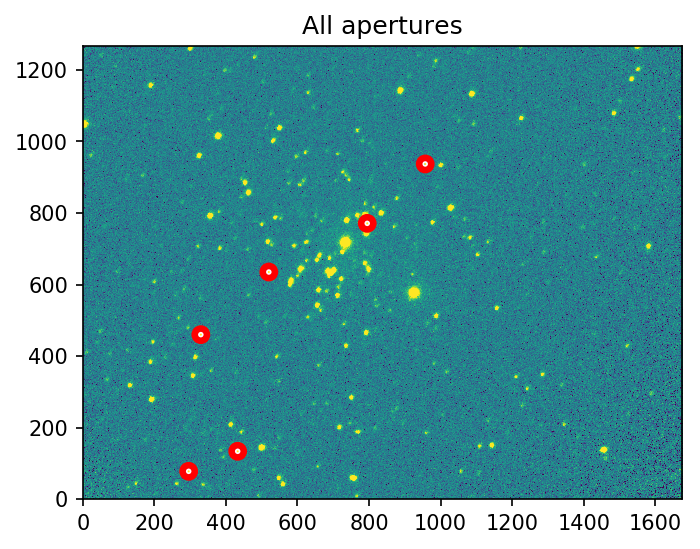

In [13]:
photometry(targ_rad=1.3, sky_inner=2.0, sky_outer=3.0)

Now, I'll repeat the exercise, but with target aperture radii of 0.5\*FWHM and 2.0\*FWHM.

Raw intensity of star (F_targ_raw): 299731.09381682717
Number of pixels in star aperture (N_targ): 36.42718679967093
Median intensity per pixel in sky aperture (F_sky_pix): 40.05972986730373
Sky-subtracted target flux (F_targ = F_targ_raw - N_targ*F_sky_pix) 298271.83055380656
--------------------------------------------------------------------------------------
Raw intensity of star (F_targ_raw): 224463.54470554442
Number of pixels in star aperture (N_targ): 36.42718679967093
Median intensity per pixel in sky aperture (F_sky_pix): 69.52451444796915
Sky-subtracted target flux (F_targ = F_targ_raw - N_targ*F_sky_pix) 221930.96223059183
--------------------------------------------------------------------------------------
Raw intensity of star (F_targ_raw): 99017.51716595786
Number of pixels in star aperture (N_targ): 36.42718679967093
Median intensity per pixel in sky aperture (F_sky_pix): 19.560436374346992
Sky-subtracted target flux (F_targ = F_targ_raw - N_targ*F_sky_pix) 98304.98549

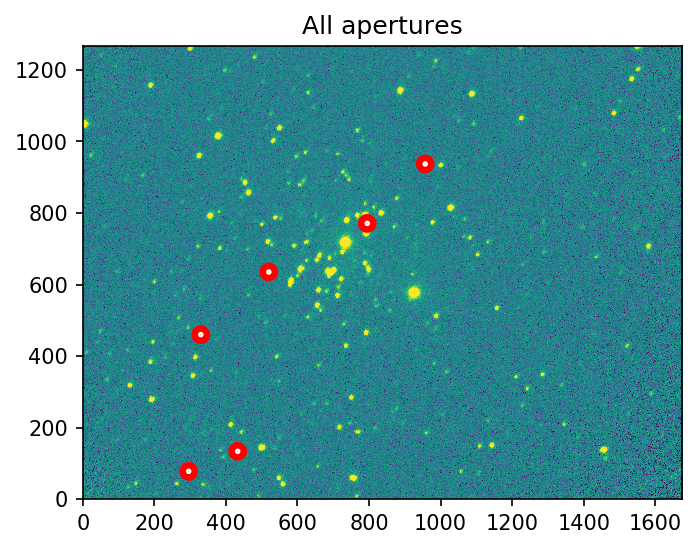

In [14]:
photometry(targ_rad=0.5, sky_inner=2.0, sky_outer=3.0)

Raw intensity of star (F_targ_raw): 778046.2933676443
Number of pixels in star aperture (N_targ): 582.8349887947348
Median intensity per pixel in sky aperture (F_sky_pix): 40.05972986730373
Sky-subtracted target flux (F_targ = F_targ_raw - N_targ*F_sky_pix) 754698.0811593143
--------------------------------------------------------------------------------------
Raw intensity of star (F_targ_raw): 574762.0244370458
Number of pixels in star aperture (N_targ): 582.8349887947348
Median intensity per pixel in sky aperture (F_sky_pix): 69.52451444796915
Sky-subtracted target flux (F_targ = F_targ_raw - N_targ*F_sky_pix) 534240.7048378043
--------------------------------------------------------------------------------------
Raw intensity of star (F_targ_raw): 255174.6674100157
Number of pixels in star aperture (N_targ): 582.8349887947348
Median intensity per pixel in sky aperture (F_sky_pix): 19.560436374346992
Sky-subtracted target flux (F_targ = F_targ_raw - N_targ*F_sky_pix) 243774.16069495

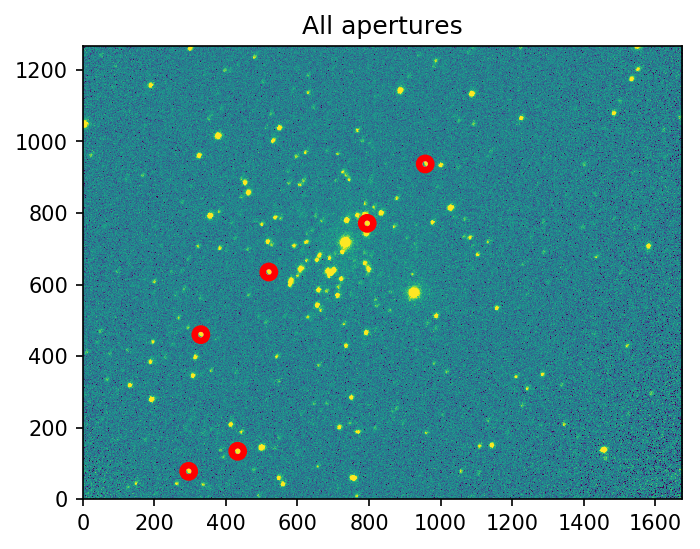

In [15]:
photometry(targ_rad=2.0, sky_inner=2.0, sky_outer=3.0)

Finally, I'll use 1.3\*FWHM for the target aperture radius (as above), but use a different sky aperture (inner radius of 1.5\*FWHM and outer radius of 3.0\*FWHM).

Raw intensity of star (F_targ_raw): 704439.1012754478
Number of pixels in star aperture (N_targ): 246.24778276577553
Median intensity per pixel in sky aperture (F_sky_pix): 49.31970048431246
Sky-subtracted target flux (F_targ = F_targ_raw - N_targ*F_sky_pix) 692294.2343845137
--------------------------------------------------------------------------------------
Raw intensity of star (F_targ_raw): 507165.6456411821
Number of pixels in star aperture (N_targ): 246.24778276577553
Median intensity per pixel in sky aperture (F_sky_pix): 79.7529051915283
Sky-subtracted target flux (F_targ = F_targ_raw - N_targ*F_sky_pix) 487526.66956863913
--------------------------------------------------------------------------------------
Raw intensity of star (F_targ_raw): 227365.56589873758
Number of pixels in star aperture (N_targ): 246.24778276577553
Median intensity per pixel in sky aperture (F_sky_pix): 23.770982881790374
Sky-subtracted target flux (F_targ = F_targ_raw - N_targ*F_sky_pix) 221512.0140

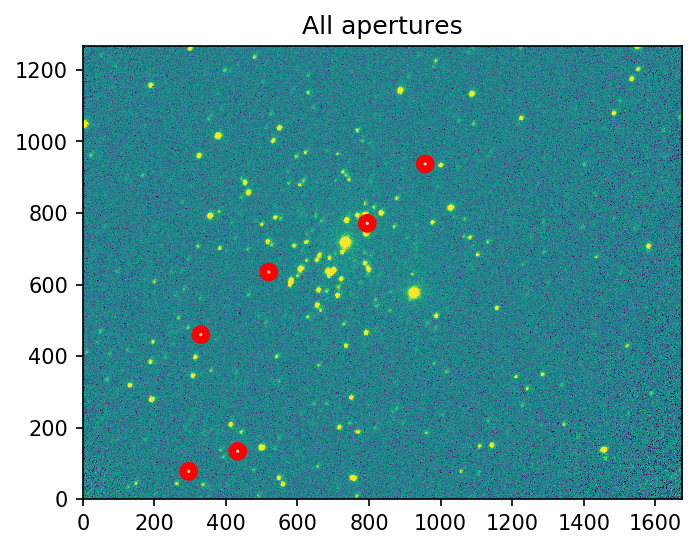

In [17]:
photometry(targ_rad=1.3, sky_inner=1.5, sky_outer=3.0)